# Introduction to Xarray


We discuss here the basic utility of Xarray here.

## Xarray is an open source Python package that extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It has a similar API to NumPy and Pandas, and supports both Dask and NumPy arrays.

In [1]:
import xarray as xa

xarray supports direct serialization and IO to several file formats, from simple Pickle files to the more flexible netCDF format (recommended).

Xarray data structures can store netCDF, and GeoTiFFs. This notebook uses Xarray to illustrate simple NDVI calculation using GeoTIFF dataset with XArray. We load L1 Landsat 8 image and compute NDVI (Normalized difference vegetation index). 

Here we explore the same dataset that we used , but use L1 this time

In [10]:
import os
import json
import rasterio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1/LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7621, 'height': 7761, 'count': 1, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 573285.0,
       0.0, -30.0, -683685.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Decimation factor= 9


Text(0, 0.5, 'Row #')

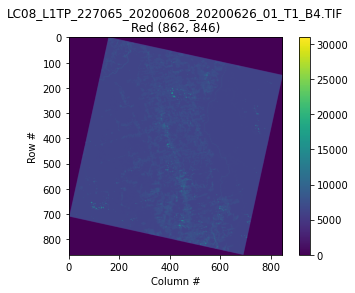

In [12]:
# Use the same example image:
date = '2020-06-08'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1/'
redband = 'LC08_L1TP_227065_20200608_20200626_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_227065_20200608_20200626_01_T1_B{}.TIF'.format(5)
mtlfile = 'LC08_L1TP_227065_20200608_20200626_01_T1_{}.json'.format('MTL')
#nirband = 'LC08_L1TP_227065_20200608_20200608_01_RT_B{}.TIF'.format(5)

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

mtlfile , needed if we need to scale to top of atmosphere reflectance. But in this tutorial, we are going to skip it

Get the block size for Xarray

In [13]:
red = rasterio.open(url+redband)
print(red.is_tiled)
red.block_shapes

True


[(512, 512)]

Create Xarray size with 512* 512 byte XArray

In [14]:
red = xa.open_rasterio(url+redband, chunks={'band': 1, 'x': 1024, 'y': 1024})
nir = xa.open_rasterio(url+nirband, chunks={'band': 1, 'x': 1024, 'y': 1024})
red

<xarray.DataArray (band: 1, y: 7761, x: 7621)>
dask.array<open_rasterio-9f84bf37cfc0ec7c9790a4b88de95308<this-array>, shape=(1, 7761, 7621), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -6.837e+05 -6.837e+05 ... -9.165e+05 -9.165e+05
  * x        (x) float64 5.733e+05 5.733e+05 5.734e+05 ... 8.019e+05 8.019e+05
Attributes:
    transform:      (30.0, 0.0, 573285.0, 0.0, -30.0, -683685.0)
    crs:            +init=epsg:32621
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

Inspecting the Dataset above, it has three dimensions (band, y, and x), similar to axes in NumPy and pandas. Index objects (also named band, x, and y), and no data variables.

## Calculate NDVI

N𝐷𝑉𝐼=𝑁𝐼𝑅−𝑅𝑒𝑑 / 𝑁𝐼𝑅+𝑅𝑒𝑑

In [15]:
ndvi = (nir - red) / (nir + red)
ndvi2d = ndvi.squeeze()

/opt/conda/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


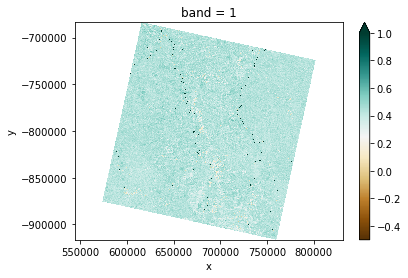

In [16]:
plt.figure()
im = ndvi2d.compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()

You can see that using Xarrays, arrays calculations become very simple. 